# Chapter 9 - Temporal forcing and time-dependent parameters 

```{contents} Table of Contents
:depth: 3
```

Up until this point, we have assumed that the dynamical systems governing the spread of a pathogen rely on a finite set of fixed parameter values. 
For example, for the SIR model, we assume that $\beta$ the transmission rate and $1/\gamma$ the average infectious period do not change over time. 

\begin{align}
    \frac{dS}{dt} &= -\beta S \frac{I}{N}\\ 
    \frac{dI}{dt} &= \beta S \frac{I}{N} - \gamma I  \\ 
    \frac{dR}{dt} &= \gamma I
\end{align}

We see that the parameter values in the above model are constants (i.e. not functions of time). 

There are many different situations where time-dependent parameters are a more appropriate way to model an outbreak.

## Intervention for compartmental models
The simplest example is when we assume that transmission has changed because of an intervention.
This was explored in Chapter 4 for the Reed-Frost model. 
For completeness we will explore an intervention model below for compartmental models. 

Assume that we wish to model the number of susceptible, infectious, and removed individuals from time $0$ to time $T$ in increments of $1$. For example, we may assume that we observe these diseases states from week 0 to week 31 in increments of one week. 

Assume that an intervention will be implemented at time $T'$.
When the intervention is implemented then it will reduce the transmission rate by a proportion $\rho$ for $0 < \rho < 1$ for $\tau$ time units. 

The above assumptions change our SIR model from one with a constant set of parameters $\theta = (\beta, \gamma)$ to a model with parameter values that depend on time. These models are (often) called **Time-dependent models** or sometimes a model with time-varying parameters, etc. 

We modify the above SIR such that the constant $\beta$ is not a function of time unit, $t$, or $\beta(t)$.
Note: Time-dependent models include models with constant parameter values. 


Our intervention model above can be specified as 

\begin{align}
    \frac{dS}{dt} &= -\beta(t) S \frac{I}{N}\\ 
    \frac{dI}{dt} &= \beta(t) S \frac{I}{N} - \gamma I  \\ 
    \frac{dR}{dt} &= \gamma I\\ 
    %
    \beta(t)       &= %
       \begin{cases}
           \rho \beta &  T' \le t \le T' + \tau \\ 
           \beta & \text{otherwise}
       \end{cases}
\end{align}

There are just two changes to move our original model to an intervention model with a time-dependent intervention:
1. The constant $\beta$ in the dynamical system changes to a time-dependent function of time $\beta(t)$
2. We need to add an additional line that describes the behavior of $\beta(t)$ over time.

Lets look at the implementation of this model in the computer. 
We'll use scipy and numpy.  
First, lets remember how to solve the original SIR *without time-dependent parameters*. 

In [1]:
import numpy as np                     #--for array and matrix computations 
from scipy.integrate import solve_ivp  #--needed to solve the ODE system 
import matplotlib.pyplot as plt        #---for plotting 

In [2]:
def sir(t,y, beta, gamma,n):
    s,i,r = y                    #<- We assume that y holds the values s,i,r at each tiny time step from start to end
    ds_dt = -beta*s*(i/n)     
    di_dt =  beta*s*(i/n) - gamma*i
    dr_dt =  gamma*i
    return [ds_dt, di_dt, dr_dt] #<-- Its our job to compute the derivatives and return them as a list

In [3]:
start = 0    #--start at time 0
end   = 20   #--end   at time 20 

#--set the number of S,I,R at time 0. 
S0 = 100
I0 = 1
R0 = 0.

#--Compute the total number of individuals (n)
n  = S0+I0+R0 

initial_conditions = (S0,I0,R0) #<--Grouped initial conditions into a tuple

#--Set values for beta and gamma
beta  = 2.0
gamma = 0.75

In [4]:
solution = solve_ivp( fun     = sir
                     , t_span = (start,end)
                     , y0     = initial_conditions
                     , args   = (beta, gamma, n) )

#--Extract solutions from the object called "solution"
times = solution.t
St    = solution.y[0,:] #<-first row  is S
It    = solution.y[1,:] #<-second row is I
Rt    = solution.y[2,:] #<-third row  is R

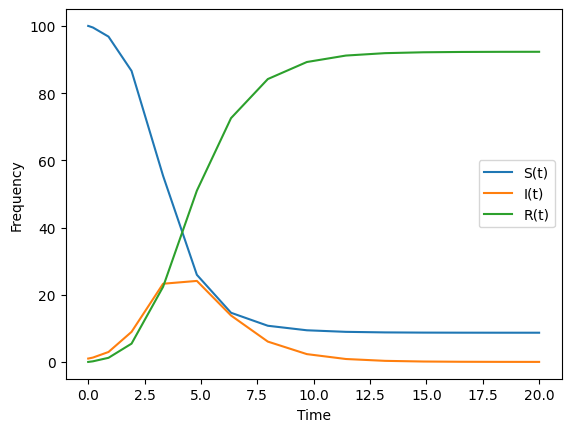

In [5]:
#--plot the results
plt.plot(times,St, label = "S(t)")
plt.plot(times,It, label = "I(t)")
plt.plot(times,Rt, label = "R(t)")

plt.xlabel("Time")
plt.ylabel("Frequency")
plt.legend()

plt.show()

To change our model to the above, time-dependent model, we need to modify the following piece of code

In [6]:
def sir(t,y, beta, gamma,n):
    s,i,r = y                    #<- We assume that y holds the values s,i,r at each tiny time step from start to end
    ds_dt = -beta*s*(i/n)     
    di_dt =  beta*s*(i/n) - gamma*i
    dr_dt =  gamma*i
    return [ds_dt, di_dt, dr_dt] #<-- Its our job to compute the derivatives and return them as a list

In the above, beta does not change as a function of $t$. 
To modify this, we will need to add a function that takes as input the value $t$ (and additionally the parameter $\rho$ as well as when the intervention begins and ends) and outputs the value of $\beta$ at time $t$. 

In [7]:
def specify_intervention_beta(t,beta, intervention_begin,intervention_end,rho):
    if t >=intervention_begin and t<=intervention_end:
        return rho*beta
    else:
        return beta

Lets specify the effectiveness of the intervention, $\rho$, and when the intervention is in effect. 

In [8]:
intervention_begin = 2.
intervention_end   = 4.
beta               = 2. 
effectiveness      = 1-0.40 # a 20% reduction in transmission

To include our time-dependent beta, we need to include in the above code a function that takes in $t$ and outputs $\beta$.
We also need our function to take as input the three parameters `intervention_begin`,`intervention_end`, and `effectiveness`. 
There are, typically two ways to do this. 

### Lambda functions
A lambda function is specified like this

In [9]:
beta_t = lambda t: specify_intervention_beta(t, 2., 2. ,4.,1-0.40)
# or---because we assigned the above variables to values---
beta_t = lambda t: specify_intervention_beta(t, beta, intervention_begin,intervention_end,effectiveness)

A lambda function is a method for creating a new inline function where you specify the inputs (after the keyword lambda) and body of the function is specified after a colon. 
Now ```beta_t``` is a function with input ```t```.

In [10]:
print(beta_t(1))
print(beta_t(2))
print(beta_t(5))

2.0
1.2
2.0


### Partial functions
A partial function is specified like this 

In [11]:
from functools import partial
beta_t = partial(specify_intervention_beta, beta = 2.,intervention_begin=2.,intervention_end=4.,rho=1-0.40  )

```Partial``` takes as input the function that you wish to prefill and values to prefill.
In our case, we want to prefill the inputs: beta, intervention_begin, intervention_end, and the input rho. 
We dont include a value for the input $t$ because we want our new function to take as input the variable $t$.
For partial, any inputs that are not pre-filled are considered to be inputs in our new function. 

print(beta_t(1))
print(beta_t(2))
print(beta_t(5))

To add in our time-dependent function, we include our pre-filled function in the dynamical system as 

In [12]:
def sir(t,y,gamma,n):
    s,i,r = y         #<- We assume that y holds the values s,i,r at each tiny time step from start to end

    beta = beta_t(t)  #<-- we see that our new beta is a function of t above. 
    
    ds_dt = -beta*s*(i/n)     
    di_dt =  beta*s*(i/n) - gamma*i
    dr_dt =  gamma*i
    return [ds_dt, di_dt, dr_dt] #<-- Its our job to compute the derivatives and return them as a list

The only change is that we assign beta to be a function that changes with changing values of $t$. 

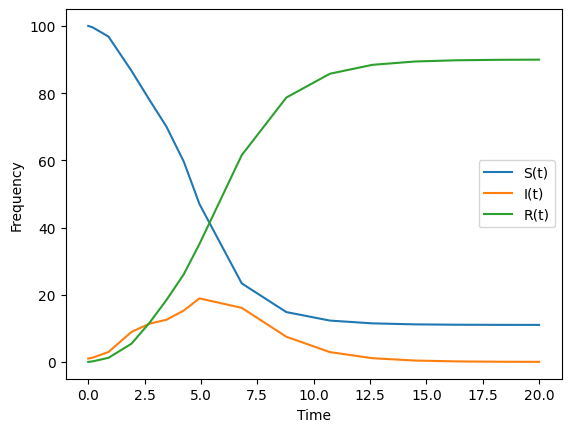

In [13]:
solution = solve_ivp( fun     = sir
                     , t_span = (start,end)
                     , y0     = initial_conditions
                     , args   = (gamma, n) )

#--Extract solutions from the object called "solution"
times = solution.t
St__intervene    = solution.y[0,:] #<-first row  is S
It__intervene    = solution.y[1,:] #<-second row is I
Rt__intervene    = solution.y[2,:] #<-third row  is R

#--plot the results
plt.plot(times,St__intervene, label = "S(t)")
plt.plot(times,It__intervene, label = "I(t)")
plt.plot(times,Rt__intervene, label = "R(t)")

plt.xlabel("Time")
plt.ylabel("Frequency")
plt.legend()

plt.show()

Lets compare the original, and intervened upon, number of infected individuals over time. 
A natural way to visualize the difference between two curves is to plot them on the same axis, overlaid. 

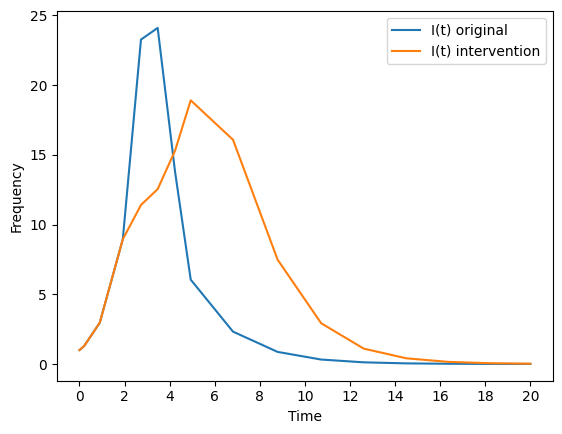

In [14]:
#--plot the results

plt.plot(times,It           , label = "I(t) original")
plt.plot(times,It__intervene, label = "I(t) intervention")

plt.xlabel("Time")
plt.ylabel("Frequency")

plt.xticks(np.arange(0,20+1,2)) #--This sets the horizontal tick marks to be in increments of 2 (0,2,4,etc). 

plt.legend()

plt.show()

## Seasonal infectious diseases

Another need for time-dependent parameters are when we wish to model seasonal infectious diseases.
Seasonal infectious diseases have alternating periods heightened and then reduced transmission.
For example, respiratory viruses like RSV and seasonal influenza in the northern hemisphere are transmitted more intensely Sept-May and then less intensely June - August.
In the southern hemisphere, RSV and seasonal influenza are more intensely transmitted from April - August. 

To model this cyclic, "up and down" trend in the transmission rate, a natural choice may be a cyclic function like the sine. That is, we could suppose that $\beta(t)$ is the function 

\begin{align}
    \beta(t) = \beta \left[1 + \alpha \sin( 2 \pi t / \lambda  ) \right]
\end{align}

This function assumes that there is a "baseline" transmission rate $\beta$.
However, this transmission rate is multiplied by "one plus" a sinusoidal component.

The sinusoidal component is 

\begin{align}
    \alpha \sin( 2 \pi t / \lambda  )
\end{align}

where $\alpha$ control the amplitude (i.e. height) of the cyclic component and $\lambda$ control the period (i.e. time between two equal values). 
Because the largest/smallest value for the since function is +1/-1, the sinusoidal component ranges from $-\alpha$ to $+\alpha$, and so then $\beta(t)$ ranges from $\beta (1-\alpha)$ to $\beta (1+\alpha)$.
Note that using $\alpha$ may introduce values for beta that are negative which is an issue. 

As an example, lets plot the transmission rate for ($\alpha = 1$, $\beta=2$,$\lambda=10$). 

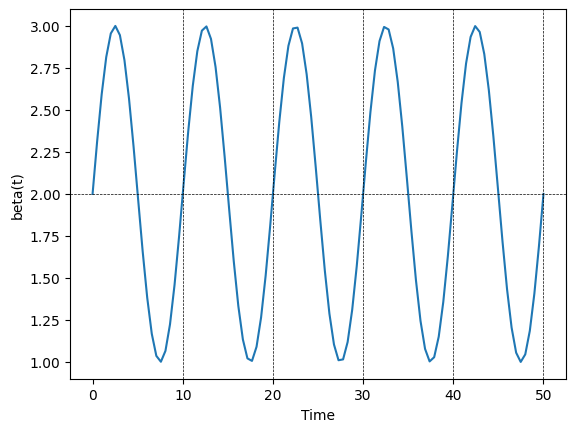

In [15]:
def seasonal_transmission_rate(t,beta,amplitude,period):
    import numpy as np
    return beta*(1 + amplitude*np.sin( 2*np.pi* t/period  ) )

fig,ax = plt.subplots()

times = np.linspace(0,50,100)

beta      = 2.
amplitude = 0.5
period    = 10.
betas     = seasonal_transmission_rate(times, beta, amplitude, period)

ax.plot(times, betas)
ax.set_xlabel("Time")
ax.set_ylabel("beta(t)")

#--add gridelines to highlight the cyclic nature of beta(t)--
ax.axhline(beta, lw=0.5, ls='--',color="black")       #--add a horizontal line at the value beta
for vline in [10,20,30,40,50]:
    ax.axvline(vline,color="black",lw=0.5, ls = "--") #--add a vertical line at the value vline

To introduce this transmission rate into a dynamical system is the same as when we introduced an intervention.

For this dynamical model, we will assume that over time those who are in the "removed" disease state move back to the "susceptible" disease state on average $1/\rho$ time units. 

This model is 

\begin{align}
    \frac{dS}{dt} &= -\beta(t) S \frac{I}{N} + \phi R\\ 
    \frac{dI}{dt} &= \beta(t) S \frac{I}{N} - \gamma I  \\ 
    \frac{dR}{dt} &= \gamma I - \phi R\\ 
    %
    \beta(t) &= \beta \left[1 + \alpha \sin( 2 \pi t / \lambda  ) \right]
\end{align}

We need to specify our time varying beta that takes as input $t$. 

\begin{align}
   f(t; A, \omega) =  A \sin(\omega t)
\end{align}
A is the amplitude or the maximum and minimum points of the function. 
The standard unit for cyclic function is $2\pi$. 

Given a function valiue $f(x)$, the **period** is the time between the inital value $f(x)$ and when the function returns to that $f(x)$ value. 
The **frequency** is the number of complete cycles that occur within 2$\pi$ time units.


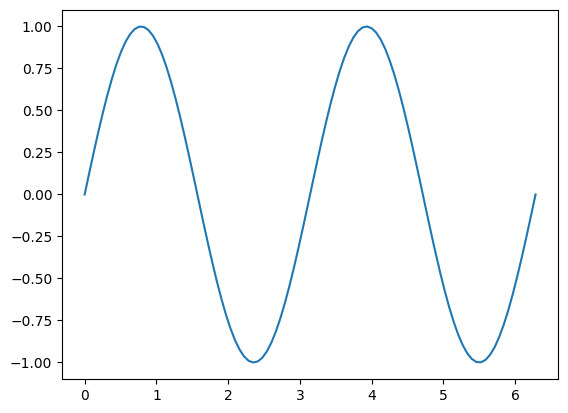

In [16]:
t = np.linspace(0,2*np.pi,100)
f = 1*np.sin( 2*t )
plt.plot(t,f)

For the example above, the sin curve completes two full cycles within a time frame of $2\pi$.
Therefore, we say that the frequency is 2 or 2 cycles per $2\pi$.
Less familiar notation may say that the frequency is $2/2\pi$ (ie 2 cycles per two pi).

If the above function completes two cycles within $2\pi$ then it must be the case that the distance, given any value $x$, the distance
between the first appearance of $f(x)$ and the second appearance of $f(x)$ is $2\pi/2$. 

In other words, the **frequency** is $\omega$ and the period is $\frac{2\pi}{\omega}$. 

Often it may be easier to reformat the sin function as follows:
\begin{align}
    A \times \sin(2\pi \omega t)
\end{align}

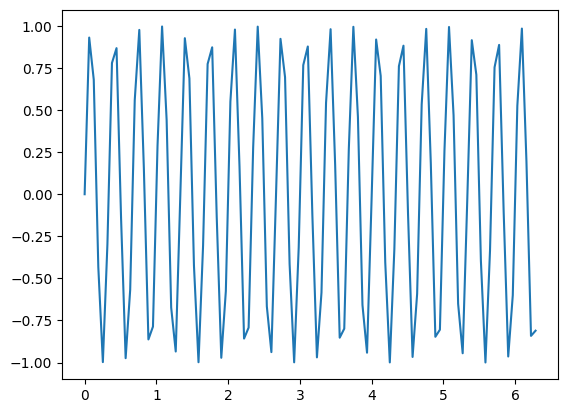

In [17]:
t = np.linspace(0,2*np.pi,100)
f = 1*np.sin( (2*np.pi)*3*t )
plt.plot(t,f)

With this formulation of the sine function, the frequency is then $2\pi \omega$  and the period is $\frac{2\pi}{2\pi \omega} = \frac{1}{\omega}$

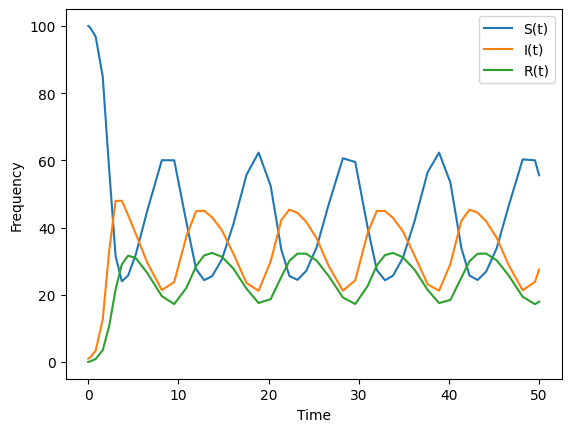

In [18]:
def seasonal_transmission_rate(t,beta,amplitude,period):
    import numpy as np
    return beta*(1 + amplitude*np.sin( 2*np.pi* t/period  ) )
beta_t = partial(seasonal_transmission_rate, beta=2, amplitude=0.5, period=10)

def sirs(t,y,gamma,phi,n):
    s,i,r = y         #<- We assume that y holds the values s,i,r at each tiny time step from start to end

    beta = beta_t(t)  #<-- we see that our new beta is a function of t above. 
    
    ds_dt = -beta*s*(i/n) + phi*r     
    di_dt =  beta*s*(i/n) - gamma*i
    dr_dt =  gamma*i - phi*r
    
    return [ds_dt, di_dt, dr_dt] #<-- Its our job to compute the derivatives and return them as a list

start = 0    #--start at time 0
end   = 50   #--end   at time 200
phi = 1.

solution = solve_ivp( fun     = sirs
                     , t_span = (start,end)
                     , y0     = initial_conditions
                     , args   = (gamma,phi, n) )

#--Extract solutions from the object called "solution"
times = solution.t
St__seasonal    = solution.y[0,:] #<-first row  is S
It__seasonal    = solution.y[1,:] #<-second row is I
Rt__seasonal    = solution.y[2,:] #<-third row  is R

#--plot the results
plt.plot(times,St__seasonal, label = "S(t)")
plt.plot(times,It__seasonal, label = "I(t)")
plt.plot(times,Rt__seasonal, label = "R(t)")

plt.xlabel("Time")
plt.ylabel("Frequency")
plt.legend()

plt.show()

As expected, when we use a period transmission rate $\beta(t)$ we find that the disease states in our epidemic model exhibit periodic behavior.
There are several periodic phenomena that could drive the transmission rate.
This is because the transmission rate is approximately the average number of contacts per small change in time multiplied by the probability of passing the pathogen between an infected and suscpetible indiviual.
In other words, $\beta(t) = p(t) \cdot C(t)$
Any phenomena that periodically changes the average number of contacts $C(t)$ or the probability of passing the pathogen $p(t)$ will then produce a period transmission rate.
Note that one of these functions can be a constant (e.g. $p(t) = p$ or $C(t) = c$). 

An example where a periodic tranmission rate may be reasonable is if we are studying a population that attends school or another seasonal event that involves congregating with many others.


Though we expect periodic transmission rates to produce periodic behavior in diseases states, are there other attributes of epidemic models that may produce periodic behavior for a **constant transmission rate**?

## Do we need temporal forcing for cyclic dynamics? 

Consider the SIR model with vital dynamics:
\begin{align}
    \frac{dS}{dt} &= \mu N -\beta S\frac{I}{N} - \mu S\\ 
    \frac{dI}{dt} &= \beta S \frac{I}{N} - \gamma I  -  \mu I\\ 
    \frac{dR}{dt} &= \gamma I  - \mu R\\ 
\end{align}

This model differs from the traditional SIR (in a closed population) because we allow for individuals to enter into the system at a rate $\mu$ and we allow for individuals to leave the system at a rate $\mu$ for any cause.
Typically, we think of entry into the system as birth and departure as death. 
However, we could consider other processes where individuals enter/leave the system. 
The crux of the modeling choice we made above is not that individuals can enter/leave the system---called an open system---but that when an individual enters the system they enter as *susceptible*.

The behavior of the SIR with vital dynamics will, for beginning time steps, mimic the behavior of the SIR model without vital dynamics. 
The number of infectors will grow exponentially up until a peak. 
After the peak infectors will decline. 
This is because there are no longer enough susceptible individuals to sustain continued propogation of the pathogen. 

The key difference between the SIR and SIR with vital dynamics is that over time individuals leaving the system in one of the three disease states are replaced by individuals who are susceptible. 
Over time, the birth rate $\mu$ will replace enough individuals with individuals in the susceptible diseease state to initiate another outbreak. 

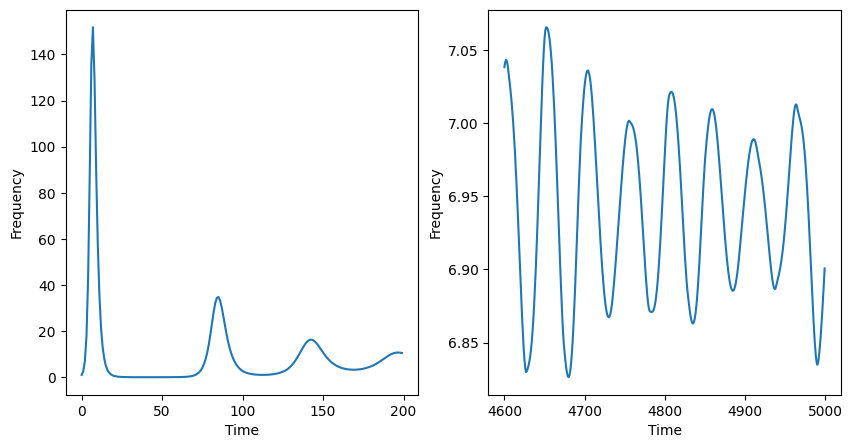

In [19]:
def sir(t,y,beta,gamma,mu,n):
    s,i,r = y         #<- We assume that y holds the values s,i,r at each tiny time step from start to end
    ds_dt =  n*mu-beta*s*(i/n)         - s*mu      
    di_dt =  beta*s*(i/n) - gamma*i    - i*mu
    dr_dt =  gamma*i                   - r*mu
    
    return [ds_dt, di_dt, dr_dt] #<-- Its our job to compute the derivatives and return them as a list

start = 0    #--start at time 0
end   = 5000   #--end   at time 200
mu    = 1./70 
gamma = 1
beta  = 2

#--set the number of S,I,R at time 0. 
S0 = 999
I0 = 1
R0 = 0.

#--Compute the total number of individuls (n)
n  = S0+I0+R0 

initial_conditions = (S0,I0,R0) #<--Grouped initial conditions into a tuple

solution = solve_ivp( fun     = sir
                     , t_span = (start,end)
                     , t_eval = np.arange(start,end,1.)
                     , y0     = initial_conditions
                     , args   = (beta,gamma,mu, n) )

#--Extract solutions from the object called "solution"
times = solution.t
St__seasonal    = solution.y[0,:] #<-first row  is S
It__seasonal    = solution.y[1,:] #<-second row is I
Rt__seasonal    = solution.y[2,:] #<-third row  is R

#--plot the results
fig,axs = plt.subplots(1,2, figsize=(10,5))

ax=axs[0]
ax.plot(times[:200],It__seasonal[:200], label = "I(t)")
ax.set_xlabel("Time")
ax.set_ylabel("Frequency")

ax=axs[1]
ax.plot(times[-400:],It__seasonal[-400:], label = "I(t)")
ax.set_xlabel("Time")
ax.set_ylabel("Frequency")

plt.show()

## Mathematical condition for future cyclic outbreaks

The *central idea* that we will explore below is:
If you can estimate over time the number (or proportion) of susceptibles in a population then you can determine whether there is a potential for an outbreak. 

We will express the mathematical condition for an outbreak and then use algebra to determine a threshold condition such that values above this threshold have outbreak potential and values below this threshold do not.


The mathematical conditions for an outbreak are when $\frac{dI}{dt}>0$.
Then this means that 
\begin{align}
        \frac{dI}{dt} &= \beta S \frac{I}{N} - \gamma I  -  \mu I > 0\\ 
                      &= \beta S \frac{I}{N} - I\left(\gamma  +  \mu\right)> 0\\
                      &\implies I \left[ \beta \frac{S}{N} - \left(\gamma  +  \mu\right) \right] > 0\\
                      &\implies \frac{I}{\gamma  +  \mu} \left[ \frac{\beta}{\gamma  +  \mu} \frac{S}{N} - 1 \right] > 0\\
                      \frac{S}{N} &> \frac{\gamma  +  \mu}{\beta }
\end{align}

This is a threshold condition for when an outbreak will occur. 
We can overlay this condition as a horizonal line and observe repeated outbreaks once this threshold is met. 
This is a core principle for cyclic or seasonal outbreaks. 
That susceptibles must replinish for repeated outbreaks.

This cyclic behavior is often called the epidemics **natural frequency**. 
We make distinct the idea of a frequency when there is no temporal forcing (the natural frequency) from a system that reaches a different frequency under forcing. 

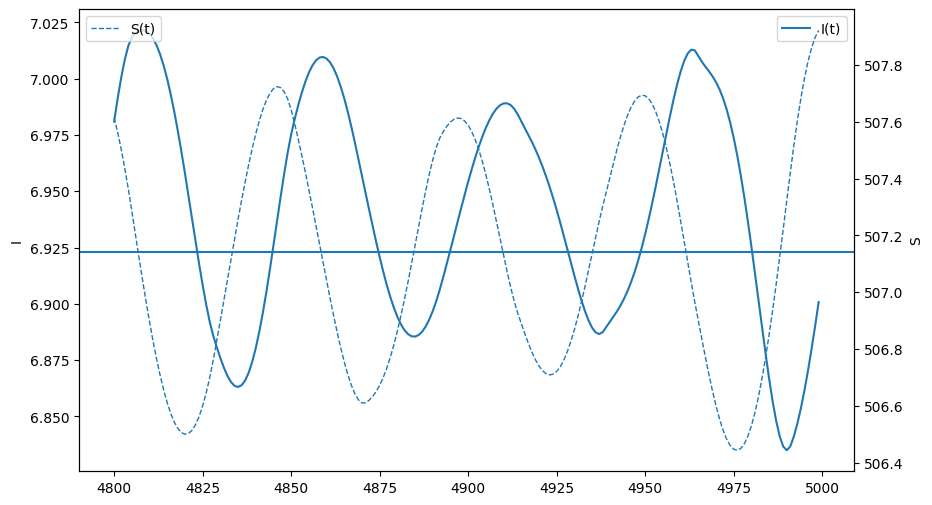

In [20]:
fig,ax = plt.subplots(figsize=(10,6))

ax.plot(times[-200:],It__seasonal[-200:], label = "I(t)")
ax.legend()
ax.set_ylabel("I")

ax = plt.twinx()
ax.plot(times[-200:],St__seasonal[-200:], label = "S(t)",lw=1,ls="--")
ax.axhline(  n*(gamma+mu)/beta )
ax.set_ylabel("S")

ax.legend()

### Fixed points

\begin{align}
    \frac{dS}{dt} &= \mu N -\beta S\frac{I}{N} - \mu S         & = 0\\ 
    \frac{dI}{dt} &= \beta S \frac{I}{N} - I (\gamma +  \mu)  & = 0\\ 
    \frac{dR}{dt} &= \gamma I  - \mu R                         & = 0\\  
\end{align}

--- 
\begin{align}
        \beta S \frac{I}{N} - I (\gamma +  \mu)  & = 0\\ 
        I\left(\gamma + \mu \right)\left[ \frac{S}{N} \mathcal{R}_{0} - 1 \right] &=0\\
        S^{*}& = \frac{N}{\mathcal{R}}
\end{align}

This implies that 
\begin{align}
        \frac{dS}{dt} = \mu N -\beta S\frac{I}{N} - \mu S         & = 0\\ 
        \mu N -\beta \frac{N}{\mathcal{R}} \frac{I}{N} - \mu \frac{N}{\mathcal{R}}         & = 0\\
        N\mu\left(1 - \frac{1}{\mathcal{R}} \right) - \beta  \frac{I}{\mathcal{R}} & =0\\
        I &= \frac{\mathcal{R}}{\beta} \left[N\mu\left(1 - \frac{1}{\mathcal{R}} \right)\right] \\ 
        I^{*} &=  \left[\frac{N\mu}{\beta}\left(\mathcal{R} - 1 \right)\right] \\ 
\end{align}

Finally, we know that $S+I+R=N$ and so the remaining disease state,$R^{*}$,is $N - \frac{N}{\mathcal{R}} - \left[\frac{N\mu}{\beta}\left(\mathcal{R} - 1 \right)\right]$. 

This fixed point is then
\begin{align}
    \left(S^{*},I^{*},R^{*}\right) = \left(\frac{N}{\mathcal{R}}, \left[\frac{N\mu}{\beta}\left(\mathcal{R} - 1 \right)\right], N - \frac{N}{\mathcal{R}} - \left[\frac{N\mu}{\beta}\left(\mathcal{R} - 1 \right)\right]  \right)
\end{align}

The other remaining fixed point is **Disease free equilibirum** or 
\begin{align}
    \left(S^{*},I^{*},R^{*}\right) = (N,0,0)
\end{align}

0.11866605518454391


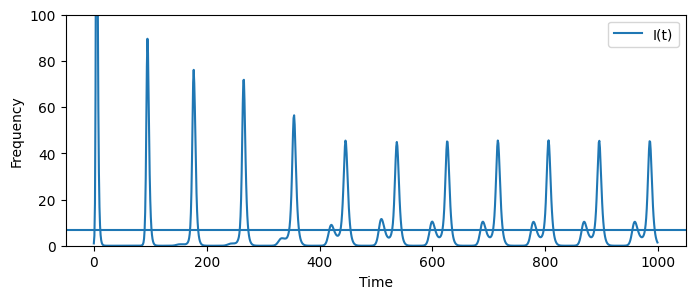

In [21]:
def seasonal_transmission_rate(t,beta,amplitude,freq):
    import numpy as np
    return beta*(1 + 0.25*np.cos( freq*t  ) )

def sir(t,y,gamma,mu,n):
    s,i,r = y         #<- We assume that y holds the values s,i,r at each tiny time step from start to end

    beta = beta_t(t)  #<-- we see that our new beta is a function of t above. 
    
    ds_dt =  n*mu-beta*s*(i/n)         - s*mu      
    di_dt =  beta*s*(i/n) - gamma*i    - i*mu
    dr_dt =  gamma*i                   - r*mu
    
    return [ds_dt, di_dt, dr_dt] #<-- Its our job to compute the derivatives and return them as a list

start = 0      #--start at time 0
end   = 1000   #--end   at time 200
gamma = 1
beta  = 2
mu    = 1./70 

repo = beta/(mu+gamma)

A = (1/mu)*(1/(repo-1))
G = 1./(mu+gamma) 
print( 1./(A*G)**0.5 )

beta_t = partial(seasonal_transmission_rate, beta=2, amplitude=0.1, freq= 0.14)

#--set the number of S,I,R at time 0. 
S0 = 999
I0 = 1
R0 = 0.

#--Compute the total number of individuals (n)
n  = S0+I0+R0 

initial_conditions = (S0,I0,R0) #<--Grouped initial conditions into a tuple


solution = solve_ivp( fun     = sir
                     , t_span = (start,end)
                     , t_eval = np.arange(start,end,1.)
                     , y0     = initial_conditions
                     , args   = (gamma,mu, n))

#--Extract solutions from the object called "solution"
times = solution.t
St__seasonal    = solution.y[0,:] #<-first row  is S
It__seasonal    = solution.y[1,:] #<-second row is I
Rt__seasonal    = solution.y[2,:] #<-third row  is R

#--plot the results
fig,ax = plt.subplots(figsize=(8,3))

plt.plot(times,It__seasonal, label = "I(t)")

plt.axhline( (n*mu/beta)*(repo-1) )

plt.xlabel("Time")
plt.ylabel("Frequency")
plt.legend()

plt.ylim(0,100)

plt.show()

In [22]:
from scipy.signal import find_peaks
peaks = find_peaks(It__seasonal)[0]
peaks = np.diff(peaks)

print(peaks)

avg_period = np.mean( peaks[5:] )

freq       = 2*np.pi/avg_period
period     = 2*np.pi/freq
print(freq)
print(period)

[56 34 58 24 89 68 21 66 25 64 27 63 26 64 26 63 27 63 27 63 26]
0.13982053534752903
44.9375


## Bifurcation diagrams

Suppose we want to study how varying the ```amplitude``` (the reader can explore any parameter value) changes the dynamics of the system. 
A first, natural, approach would be to plot many figures of (say) infections over time for a finite set of amplitudes for our infectious disease model.

The model we will study is defined as 

\begin{align}
    \frac{ds}{dt} &= \mu - \beta(t) s i - \mu s \\ 
    \frac{de}{dt} &= \beta(t) s i - \sigma e - \mu e \\ 
    \frac{di}{dt} &= \sigma e - \gamma i - \mu i \\ 
    \frac{dr}{dt} &= \gamma i - \mu r\\ 
    %
    \beta(t) &= \beta \left[1 + \alpha \cos( 2 \pi t / 365  ) \right]
\end{align}

where our time units $(t)$ are days.
We assume individuals can be in disease states: susceptible, exposed (or latent), infectious, and removed. 
The transmission rate $\beta(t)$ is periodic with period (i.e. repeats) one year and behaves similar to a cosine wave. 
The lowercase state variables s,e,i,r describe the **proportion** of individuals in each disease state.

Note that the parameter $\mu$ is the rate of new individuals entering the system, and that we expect those who enter the system to be susceptible. We also expect a proportion of individuals in each state to die (for example $\mu s$).  
We will run the system daily for 200 years and plot the last decade proportion of infections. 
We run the system for so long to make sure that the system (hopefully) has moved into an attractor. 
This example is taken from *Modeling Infectious Diseases in Humans and Animals by Keeling and Rohani*.

In [ ]:
def explore_amplitude_parameter(amplitude):
    def seasonal_transmission_rate(t,beta,amplitude,period):
        import numpy as np
        return beta*(1 + amplitude*np.cos( 2*np.pi* t/period  ) )

    #--THIS IS WHERE THE PARAMETER PERIOD IS USED-------------------------------------
    beta_t = partial(seasonal_transmission_rate, beta=1250./365, amplitude=amplitude, period=365)
    #---------------------------------------------------------------------------------
    
    def sirs(t,y,gamma,sigma,phi,n):
        s,e,i,r = y         #<- We assume that y holds the values s,i,r at each tiny time step from start to end
    
        beta  = beta_t(t)  #<-- we see that our new beta is a function of t above. 

        ds_dt =    mu-beta*s*i         - mu*s      
        de_dt =  beta*s*i   - sigma*e  - mu*e
        di_dt =  sigma*e    - gamma*i  - mu*i
        dr_dt =  gamma*i               - mu*r
        
        return [ds_dt,de_dt, di_dt, dr_dt] #<-- Its our job to compute the derivatives and return them as a list

    #--This part is an ode trick---------------------------------------------------------------
    #--im using this because i know the solution is positive and sensitive to small changes. 
    def log_seir(t,log_y,gamma,sigma,phi,n):
        y    = np.exp(log_y)
        dydt = np.array(sirs(t,y,gamma,sigma,phi,n))
        return dydt/y
    #------------------------------------------------------------------------------------------

    start = 0       #--start at time 0
    end   = 365*300 #--end in 300 years

    #--parameters
    gamma = 1./5
    sigma = 1./8
    mu    = 0.02/365

    #--initial conditions 
    S0 =  6*10**-2
    E0 =  10**-3
    I0 =  10**-3
    R0 =  1-(S0+E0+I0)
    
    #--Compute the total number of individuals (n)
    n  = S0+E0+I0+R0 
    
    initial_conditions = (S0,E0,I0,R0) #<--Grouped initial conditions into a tuple

    solution = solve_ivp( fun     = log_seir
                         , t_span = (start,end)
                         , t_eval = np.arange(0,end+1,1)
                         , y0     = np.log(initial_conditions)
                         , atol   =1e-9
                         , rtol   =1e-9
                         , args   = (gamma,sigma,phi, 1) )
    
    #--Extract solutions from the object called "solution"
    times = solution.t
    St__seasonal    = solution.y[0,:] #<-first row  is S
    Et__seasonal    = solution.y[1,:] #<-second row is E
    It__seasonal    = solution.y[2,:] #<-second row is I
    Rt__seasonal    = solution.y[3,:] #<-third row  is R

    return times, np.exp(It__seasonal)

fig,axs = plt.subplots(2,2,figsize=(10,6))

#--first plot 
ax = axs[0,0]
times,I = explore_amplitude_parameter(0.02)
ax.plot(times[-365*10:],np.log(I[-365*10:]), label = "I(t), lambda=1")
ax.set_ylabel("Log Proportion of I")

#--next plot 
ax = axs[0,1]
times,I = explore_amplitude_parameter(0.1)
ax.plot(times[-365*10:],np.log(I[-365*10:]), label = "I(t), lambda=2")

#--next plot 
ax = axs[1,0]
times,I = explore_amplitude_parameter(0.225)
ax.plot(times[-365*10:],np.log(I[-365*10:]), label = "I(t), lambda=3")
ax.set_ylabel("Log Proportion of I")

time_units = times[-365*10:]
ax.set_xticks( time_units[::365]  )

#--next plot 
ax = axs[1,1]
times,I = explore_amplitude_parameter(0.30)
ax.plot(times[-365*10:],np.log(I[-365*10:]), label = "I(t), lambda=3")

time_units = times[-365*10:]
ax.set_xticks( time_units[::365]  )


plt.show()

Its cumbersome to have to generate many plots to understand the impact of the amplitude on the dynamics of this model. 
Another option is to vary the amplitude and compute a summary statistic over the most recent (say) 10 years. 
Again, we will turn to the bifurcation diagram to better understand the behavior of our system.

In our example, we will plot the proportion of infections on the last (365th) day of the year for the most recent 10 years. 

In [ ]:
from scipy.signal import find_peaks
import sys

#--these are the range of parameter values that i want to explore
amplitudes = np.linspace(0,0.4,50)

fig,ax = plt.subplots()

for amplitude in amplitudes: #<--for each individual parameter value 
    #sys.stdout.write("\r{:.3f}\r".format(amplitude))
    
    times,infectors = explore_amplitude_parameter(amplitude) #<--run the ode

    infectors_after_one_year = infectors[-10*365:]           #<--extract the last 10 years (when the ode has stabilized)
    
    samples_every_year = infectors_after_one_year[::365]                                #<-- Look at every 365th day
    n_years = len(samples_every_year)                                                   #<--Compute the number of years
    
    ax.scatter( [amplitude]*n_years, np.log10(samples_every_year) ,s=1, color="black" ) #--Plot 

ax.set_xlabel("Amplitude")
ax.set_ylabel("log(proportion of infectors)")
plt.show()

We see that, even for a relatively straightforward outbreak model, different parameter values can produce very different qualitative behaviors.
In this case, smaller amplitudes create a single annual cycle. 
Larger values create a bi-annual cycle, and even larger values create a chaotic mix of cycles. 
Depending on the observed system, a small change to the amplitude can produce drastically different behaviors. 

## Homework 

1. **Intervention challenge**
    1. Package the above intervention model so that the input is $\rho$, the start time for the intervention, and the end time for the intervention. The output of the function is the remaining number of susceptibles.
    2. Run the above function for $\rho$ from 0,1 by 0.05 and fixed start time equal to 2 and end time equal to 5. Plot the number of susceptibles for each value of $\rho$.
2. **When and how intense of an intervention?** : Assume that an intervention can be deployed for exactly 4 weeks (about a month). Health officials can decide to deploy more or less resources that would result in a potential reduction in transmission between 40\% and 60\%. Health officials have measured past trajectories for the infectious agent they wish to target. The model is assumed to be a SEIR model and the estimated parameter values are $\sigma = 1/1.1$, $\gamma = 1.$, $\beta = 3$; and the observational period is 30 weeks.
   1. Produce a dataframe with three columns: start, rho, sus that records the number of susceptibles at the end of week 30 (sus), in what week the intervention was started (start), and the reduction in the transmission rate (rho).
   2. Use the above dataframe to produce a heatmap of number of susceptibles using seaborn's heatmap function. 
3. **Initial conditions** Take the function ```explore_amplitude_parameter``` and run this model for four different initial conditions:
   1. S=$6 \times 10^-2$             ; I=$10^{-3}$; E=$10^{-3}$
   2. S=$1.01 \times 6 \times 10^-2$ ; I=$10^{-3}$; E=$10^{-3}$
   3. S=$6 \times 10^-2$             ; I=$1.01 \times 10^{-3}$; E=$10^{-3}$
   4. S=$6 \times 10^-2$             ; I=$10^{-3}$; E = $1.01\times 10^{-3}$
Use the same gamma, sigma, and mu parameters as in the notes. Include an amplitude of 0.25.
Plot log(I) over time for each of the above scenarios.   

All of the parameters for this dynamical system are the same, only the initial conditions change for the four scenarios. Even more, this model is run for a long enough time to each a fixed point. Why are you observing qualitatively different behaviors?     

4. **Forcing functions** We will use again the same model in Question 3 (the same model in the notes) and modify the forcing function. Suppose that time $t$ is in days and so we will consider the value 365 (and every multiple) an elapsed year. Please change the forcing function to be $\beta(t) = \beta \left[1 + 0.25 g(t)  \right]$ where $g$ equals the value one during the first half of the year (days 0-179; 365-545; etc) and the value -1 otherwise. This is an alternative method for producing periodic behavior. Plot log(I(t)) for the same 4 scenarios above.
   
How does this periodic forcing function compare to the sinusoidal forcing function above? 